# Neural Networks - MNIST

Previously, I have worked on classifying the MNIST(Handwritten digits) data using Linear Regression, KNN, Naive Bayes, Logistic Regression, SVM, and Neural Networks. But for the neural networks, I have used scikit-learn library. Even though I understand the internal woeking of a stotastic gradient decent, I haven't had the chance to implement it the last time. So now, I'm going to implement a Neural Network from the scratch.

In [1]:
# Importing statements

# For extracting and loading the data
import pickle, gzip
# For math computations
import numpy as np
# To randomly initialize bias and weights for the first initialization
import random
# To clock the time taken
import time
# To plot the accuracy and classification results
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Extracting the .pkl file and loading it as training, validation, and test data sets.
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as file :
        u = pickle._Unpickler(file)
        # There is some weird encoding problem when switching from py2 - py3, so have to use this encoding.
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    return (train_set, valid_set, test_set)


def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    testing_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, testing_data)

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
training_data, validation_data, testing_data = load_data_wrapper()

In [4]:
class Network(object):

    def __init__(self, hidden_layers_sizes):
        # The initialization parameter takes in the array containing 
        # number of hidden layers. As this problem's input is a 28*28
        # pixel data, the first(input) layer is 784 and the output layer 
        # is 10 as we need classification of digits from 0-9.
        hidden_layers_sizes.insert(0, 784)
        hidden_layers_sizes.insert(len(hidden_layers_sizes), 10)
        self.num_layers = len(hidden_layers_sizes)
        self.hidden_layers_sizes = hidden_layers_sizes
        
        
        # The biases and weights for the network are initialized 
        # randomly, using a Gaussian distribution with mean 0, 
        # and variance 1.  Note that the first layer is assumed 
        # to be an input layer, and by convention we won't set 
        # any biases for those neurons, since biases are only
        # ever used in computing the outputs from later layers.
        self.biases = [np.random.randn(y, 1) for y in hidden_layers_sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(hidden_layers_sizes[:-1], hidden_layers_sizes[1:])]

    def classify(self, x):
        # Simply compute W*x+B
        for b, w in zip(self.biases, self.weights):
            x = self.sigmoid(np.dot(w, x)+b)
        return x

    def SGD(self, training_data, epochs, mini_batch_size, learning_rate,
            testing_data=None):
        self.accuracy = np.zeros(epochs)
        self.correct_classification_count = np.zeros(epochs)
        # Here we train the neural network using stochastic
        # gradient descent in batches. 
        # We randomly shuffle the data and pick a certain sized
        # batch to perform the model training and weight updations
        if testing_data: n_testing_data = len(testing_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            # Self explanatory - Evaluate the model by classifying
            # on every iteration if there is test data available.
            if testing_data:
                self.correct_classification_count[j] = self.evaluate(testing_data)
                self.accuracy[j] = (self.correct_classification_count[j]/n_testing_data)*100
        fig = plt.figure(figsize=(20,10))
        fig.suptitle("Accuracy VS Epoch Graph")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(self.accuracy)
        print("Maximum Accuracy = ",max(self.accuracy),"%")        

    def update_mini_batch(self, mini_batch, learning_rate):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``learning_rate``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(learning_rate/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(learning_rate/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # classify
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, testing_data):
        # Returns the number of test inputs for which the neural
        # network outputs the correct result. Note that the neural
        # network's output is assumed to be the index of whichever
        # neuron in the final layer has the highest activation.        
        test_results = [(np.argmax(net.classify(x)), y) 
                        for (x, y) in testing_data]
        return sum(int(x==y) for (x, y) in test_results)
    
    def check_wrong_evaluations(self, testing_data):
        # Returns the number of test inputs for which the neural
        # network outputs the correct result. Note that the neural
        # network's output is assumed to be the index of whichever
        # neuron in the final layer has the highest activation.        
        self.wrong_classifications = []
        test_results = [(np.argmax(net.classify(x)), y) 
                        for (x, y) in testing_data]
        count = 0
        for index,(x, y) in enumerate(test_results):
            if(int(x != y)):
                self.wrong_classifications.append(index)
            else:
                count+=1
        return count;

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z)*(1-self.sigmoid(z))

The Layers in the NN are:  [784, 10]
Maximum Accuracy =  84.13 %
Time taken =  33.89525580406189 s


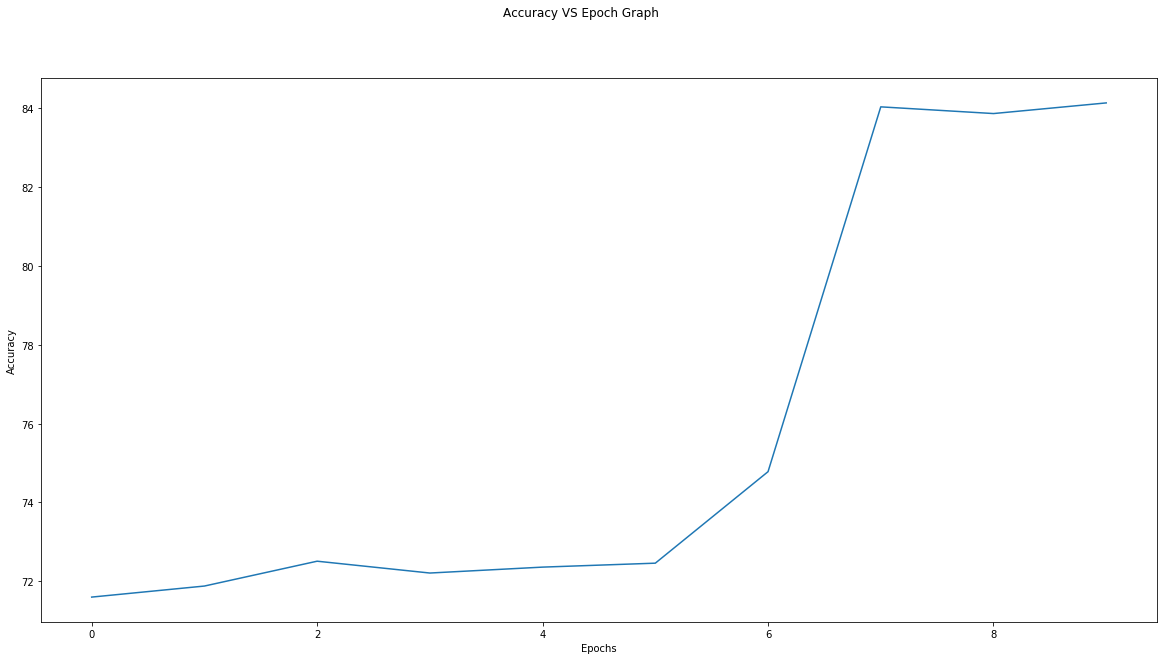

In [5]:
net = Network([])
print("The Layers in the NN are: ",net.hidden_layers_sizes)
start = time.time()
net.SGD(training_data, 10, 5, 3, testing_data=testing_data)
print ("Time taken = ", time.time()-start,"s")

In [7]:
def plot_mnist_digit(x):
    # This function plots the digit given a 28*28 matrix.
    fig = plt.figure(figsize=(15, 15))
    size = len(x)
    i = size/4
    j = 1
    for k in x:
        image = np.reshape(testing_data[net.wrong_classifications[k]][0],(28,28))
        ax = fig.add_subplot(i, 4, j)
        ax.matshow(image, cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        j+=1
        #print("Actual Value: ",testing_data[net.wrong_classifications[k]][1])
        #print("Predicted Value: ",np.argmax(net.classify(testing_data[net.wrong_classifications[k]][0])))
    plt.show()

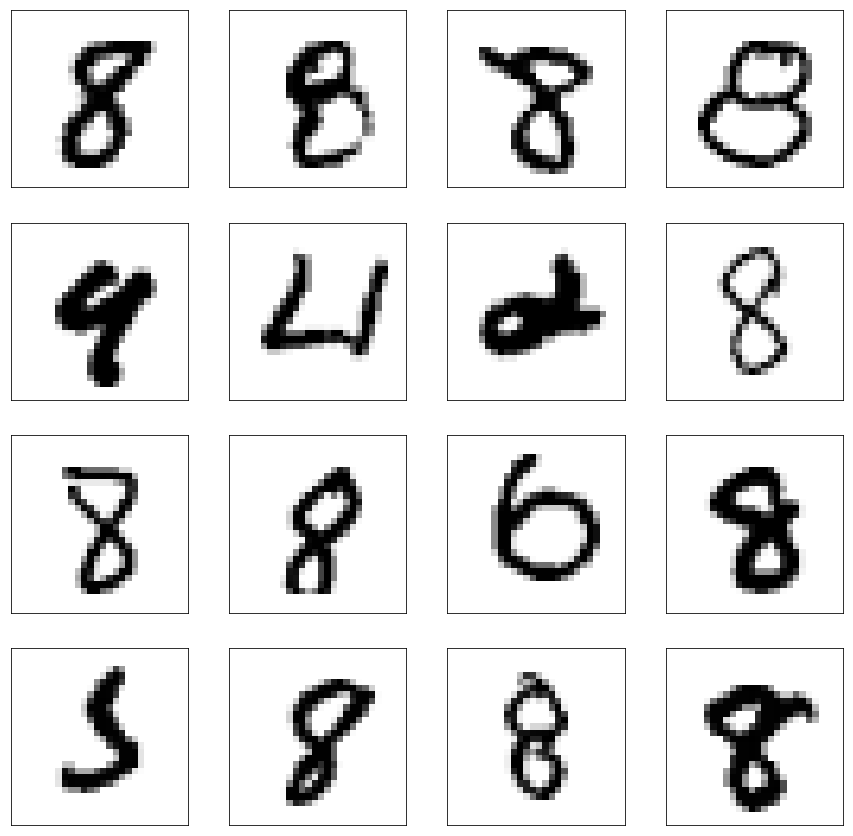

In [9]:
# Let us plot some digits with their correct classification 
# This enables us to visualize how they are structured.
net.check_wrong_evaluations(testing_data)
x = [random.randint(0,len(net.wrong_classifications)-1) for i in range(1,17)]
plot_mnist_digit(x)

In [105]:
def plot_really_bad_images():
    """This takes a list of the worst images from plot_bad_images and
    turns them into a figure."""
    really_bad_image_indices = [
        324, 582, 659, 726, 846, 956, 1124, 1393,
        1773, 1868, 2018, 2109, 2654, 4199, 4201, 4620, 5457, 5642]
    n = len(really_bad_image_indices)
    really_bad_images = [np.reshape(testing_data[j][0],(28,28)) for j in really_bad_image_indices]
    fig = plt.figure(figsize=(15, 10))
    for j in range(1, n+1):
        ax = fig.add_subplot(3, 6, j)
        ax.matshow(really_bad_images[j-1], cmap = matplotlib.cm.binary)
        #ax.set_title(str(really_bad_image_indices[j-1]))
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

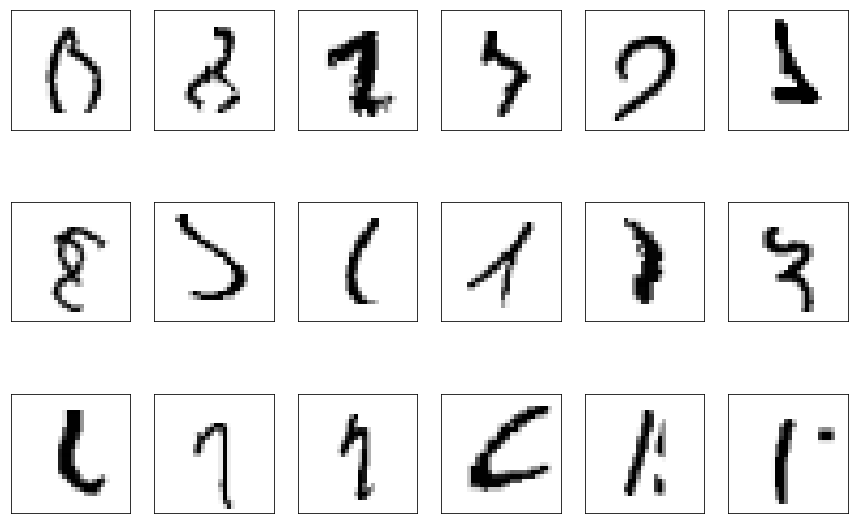

In [106]:
plot_really_bad_images()